In [1]:
## Breast Cancer Classification Transfer Learning VGG16
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import tensorflow as tf

from sklearn.utils import class_weight  # Import class_weight
from sklearn.metrics import confusion_matrix, classification_report

2025-05-07 14:45:41.559972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 14:45:41.593674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 14:45:41.599366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 14:45:41.617018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 14:45:42.588070: W tensorflow/compiler/tf2

In [2]:
### Creating Dataset
print(os.listdir('../breast_full_dataset'))

### Train Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as base_preprocess

['Benign', 'Malignant']


In [3]:
image_gen = ImageDataGenerator(
                               #preprocessing_function=base_preprocess,
                               validation_split=0.15)
data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224,224)

train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


In [3]:
image_gen = ImageDataGenerator(
                               #preprocessing_function=base_preprocess,
                               validation_split=0.15)
data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224,224)

train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

image = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.
Found 7632 images belonging to 2 classes.


In [7]:
# Here, we add random rotation, zoom, brightness, vertical flip, etc.
image_gen = ImageDataGenerator(
    preprocessing_function=base_preprocess,
    validation_split=0.15,
    rotation_range=20,        # Random rotation in degrees
    #zoom_range=0.1,           # Random zoom
    brightness_range=[1.0, 1.5],  # Brightness adjustment
    vertical_flip=True,       # Flip vertically
)

data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224, 224)

train_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset="training"
)

test_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset="validation"
)

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch a batch of images (and their labels) from the training generator
images, labels = next(train_image_gen)  # images.shape == (batch_size, height, width, channels)

# Display the first 5 images (or as many as you like)
num_to_show = len(images)
for i in range(num_to_show):
    plt.figure()  # Create a new figure for each image
    plt.imshow(images[i])  # Convert floats to uint8 for display (if needed)
    plt.title(f"Label index: {np.argmax(labels[i])}")  # Convert one-hot to class index (if categorical)
    plt.axis('off')
    plt.show()


In [4]:
print(test_image_gen.class_indices)
train_labels = train_image_gen.classes  # Extracts the classes (integer encoded labels)

{'Benign': 0, 'Malignant': 1}


In [5]:
# Get the unique class names and their corresponding indices
class_names = list(train_image_gen.class_indices.keys())
print(f"Class names: {class_names}")

Class names: ['Benign', 'Malignant']


In [6]:
# Compute class weights based on the labels
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

# Create a dictionary mapping class indices to weights
class_wt_dict = dict(enumerate(class_weights))

# Output the computed class weights
print(f"Class weights: {class_wt_dict}")

Class weights: {0: np.float64(1.5144724556489262), 1: np.float64(0.7464335020708698)}


In [1]:
## Transfer Learning using VGG16 Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in x_model.layers[:-1]:
    layer.trainable = False

x = x_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
tl_model = Model(inputs=x_model.input, outputs=x)

optimizer = "Adam"
tl_model.summary()
tl_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

2025-05-07 16:00:42.356063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 16:00:42.373404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 16:00:42.378400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 16:00:42.391080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 16:00:43.482089: W tensorflow/compiler/tf2

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 74,971,522 (285.99 MB)

 Trainable params: 51,382,786 (196.01 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Clear the session
tf.keras.backend.clear_session()

# Reset the tracked memory stats
tf.config.experimental.reset_memory_stats('GPU:0')

I0000 00:00:1740637226.726481   17973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4778 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [23]:
## Model Training
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

filename = "models3/t3_breast_ResNet50_NoPreProcess-epoch{epoch:02d}.keras"
dirname = "logs_test2/breast_ResNet50Adam_NoPreProcessing"

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint(filepath= filename, save_best_only=True, monitor='val_accuracy',verbose=1)
tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

#callback_list = [model_chkpt, lr_reduce, early_stop, tensorboard]
callback_list = [model_chkpt, lr_reduce, tensorboard]
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

Epoch 1/20


/home/mr/workspace/MajorProject/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-02-24 16:16:13.014753: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operatio

811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6107 - loss: 0.8446
Epoch 1: val_accuracy improved from -inf to 0.65822, saving model to models3/t3_breast_ResNet50_NoPreProcess-epoch01.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 71s 74ms/step - accuracy: 0.6108 - loss: 0.8444 - val_accuracy: 0.6582 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8299 - loss: 0.4058
Epoch 2: val_accuracy did not improve from 0.65822
811/811 ━━━━━━━━━━━━━━━━━━━━ 89s 109ms/step - accuracy: 0.8299 - loss: 0.4058 - val_accuracy: 0.6547 - val_loss: 0.7626 - learning_rate: 0.0010
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8674 - loss: 0.2930
Epoch 3: val_accuracy improved from 0.65822 to 0.71678, saving model to models3/t3_breast_ResNet50_NoPreProcess-epoch03.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 125s 154ms/step - accuracy: 0.8674 - loss: 0.2930 - val_accuracy: 0.7168 - val_loss: 0.7652 - learning_rate: 0.0010
Epoch 4/20
811/81

2025-02-24 16:59:08.384184: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at summary_kernels.cc:150 : RESOURCE_EXHAUSTED: logs_test2/breast_ResNet50Adam_NoPreProcessing/train/events.out.tfevents.1740393964.pop-os.7712.2.v2; No space left on device
	Failed to flush 11 events to logs_test2/breast_ResNet50Adam_NoPreProcessing/train/events.out.tfevents.1740393964.pop-os.7712.2.v2
	Could not flush events file.
2025-02-24 16:59:08.384211: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: RESOURCE_EXHAUSTED: logs_test2/breast_ResNet50Adam_NoPreProcessing/train/events.out.tfevents.1740393964.pop-os.7712.2.v2; No space left on device
	Failed to flush 11 events to logs_test2/breast_ResNet50Adam_NoPreProcessing/train/events.out.tfevents.1740393964.pop-os.7712.2.v2
	Could not flush events file.


ResourceExhaustedError: {{function_node __wrapped__WriteSummary_device_/job:localhost/replica:0/task:0/device:CPU:0}} logs_test2/breast_ResNet50Adam_NoPreProcessing/train/events.out.tfevents.1740393964.pop-os.7712.2.v2; No space left on device
	Failed to flush 11 events to logs_test2/breast_ResNet50Adam_NoPreProcessing/train/events.out.tfevents.1740393964.pop-os.7712.2.v2
	Could not flush events file. [Op:WriteSummary]

In [24]:
### Model Evaluation
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist2.csv')
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()
metrics[["accuracy","val_accuracy"]].plot()
tl_model.evaluate(test_image_gen)
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


OSError: [Errno 28] No space left on device

In [12]:
test_labels = test_image_gen.classes
from tensorflow.keras.models import load_model

final_model = load_model("./final models/t3_breast_ResNet50_NoPreProcess-epoch15.keras")
predictions = final_model.predict(image, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = image.classes

/home/mr/workspace/MajorProject/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


954/954 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step


Normalized confusion matrix
[[0.94722222 0.05277778]
 [0.03579812 0.96420188]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2520
           1       0.97      0.96      0.97      5112

    accuracy                           0.96      7632
   macro avg       0.95      0.96      0.95      7632
weighted avg       0.96      0.96      0.96      7632



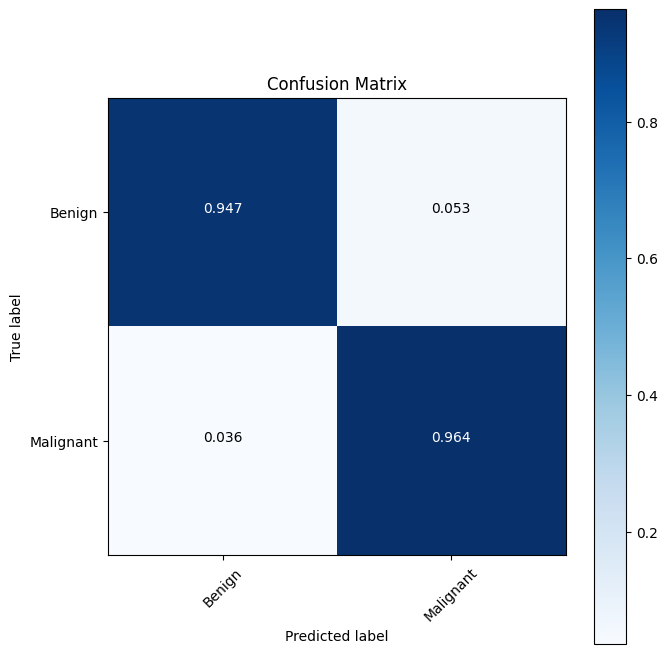

In [14]:
cm = confusion_matrix(test_labels, predictions)
cm
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)
print(classification_report(image.classes, predictions, zero_division=0))


In [11]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.50      0.65      0.57       378
           1       0.80      0.68      0.73       766

    accuracy                           0.67      1144
   macro avg       0.65      0.66      0.65      1144
weighted avg       0.70      0.67      0.68      1144

